# **Pre-processing Seismic 2-D Crop with the Fourier Transform**

Clone the dataset to perform the analysis

In [47]:
!git clone https://github.com/bintanpradika/geoscience_petroleum.git
!cp -a geoscience_petroleum/FourierTransformSeismic/ data/
!rm -rf geoscience_petroleum sample_data

Cloning into 'geoscience_petroleum'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (19/19), done.


In [48]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import seaborn as sns
from IPython.display import Audio
from IPython.display import YouTubeVideo
from IPython.display import IFrame

sns.set()

Now for this part you are given a seismic section that needs to be interpreted. As you can see, it is quite noisy.

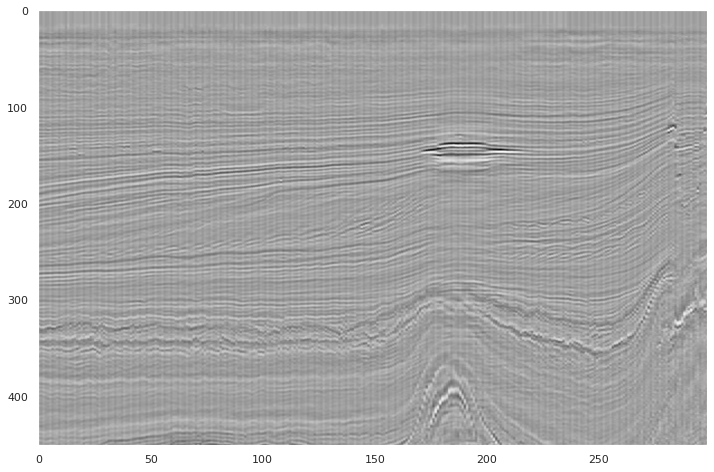

In [49]:
def print_seis(seismic):
    plt.figure(figsize=(12, 8))
    plt.imshow(seismic, cmap='Greys', aspect='auto')
    plt.grid(False)
    plt.show()
    
noisy_seismic = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
sample_rate = 250 #Hz
print_seis(noisy_seismic)

'noisy_seismic.npy' data. It consist of 451 rows and 299 columns. Value for given [row index, column index] is waveform or signal value. As shown by print_seis(noisy_seismic), y-axis is noisy_seismic.npy' data rows (451), and x-axis is noisy_seismic.npy' data columns (299), thus y-axis_max is the duration (duration = 451 ms (TWT in ms)). x-axis is trace number (299 traces).







### **Method 1: Clean Image based on wiggle or signal = data[twt,:], it is defined that signal is per layer (TWT)**

For each trace:
1. Create **Frequency domain** (amplitude vs frequency) to find where is the noise using **Fourier Transform**--> ***fourier_visual_freq_domain(twt)***. It is consist of:
  1. **Signal tappering** --> signal = signal * np.blackman(signal.size)
  2. Define **fourier coefficient** --> S = np.fft.fft(signal), freq = np.fft.fftfreq(signal.size, d=1/sample_rate), x, y = freq[:S.size], S[:S.size], (where x is frequency and y is amplitude). In seismic noise removal, it is extremely important to keep frequency and amplitude in its positive and negative form.
  3. As seen in **Visualization Inspection for all TWT using frequency domain (uncleaned)**, it conclude that noise is where 80 < freq (Hz) < 90
  4. As seen in **Max Absolute Amplitude of the Noise for Each TWT for Frequency between 80 - 90 Hz**, it found out that for each TWT, the **noise amplitude is around 50,000**

Note that step 1 is written to explain exact value of noise frequency and noise amplitude
2. **Delete the amplitude where the noise is exist** using --> ***fourier_cleansing(twt, freq_min, freq_max)***
  1. Find the index where the frequency is between freq_min and freq_max --> *noise_index = np.where((x>freq_min)&(x<freq_max))*
  2. Delete that amplitude for all that index --> *S[noise_index] = 0*
  3. Since it has negative frequency, find the index where the frequency is between -freq_max and -freq_min --> noise_index = np.where((x>-freq_max)&(x<-freq_min)) --> then delete the amplitude --> *S[noise_index] = 0*
  4. Note that each TWT has different configuration of frequency and amplitude noise.
  5. Store the data into x, y = freq[:S.size], S[:S.size]. x is original frequency while y is cleaned amplitude. Later x,y will be used in clean_freq, celan _amp
3. Perform **Inverse Fourier using** --> ***inverse_fourier(twt)***
  1. s = np.fft.ifft(clean_amp[twt,:])
  2. Note that Fourier Transform and Inverse Fourier can create an imajiner values, thus the clean_s we used should be the real value (clean_s_real)
  2. Finally **show the clean seismic** using print_seis(clean_s_real)

However, We know that waveform (or wavelet) or wiggle in seismic is vertically shown for any given x-axis in the dataset given. Therefore, Method 2 also can be used in this analysis.

### **Method 2: Clean Image based on wiggle or signal = data[:,trace], it is defined that signal is per trace**
Note that in this method, deleting the amplitude of the noise based on the amplitude selection (not frequency selection) to give better result.

Discussion: defining frequency and amplitude of noise should be based on clear assumption on how we define the signal. Either signal per TWT or signal per trace. The degree of satisfaction on working cleaning the noise rely on how satisfied the geophysicts interprets the ***'after noise cleansing'***. For the purpose of this report, I satisfied with the cleaning noise result based on assumption that signal is per trace (Method 2) because it gives better result.

# **Method 1: Clean Image based on wiggle or signal = data[twt,:], it is defined that signal is per layer (TWT)**

In [50]:
data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')

### **Visualization Inspection for all TWT using frequency domain (uncleaned)**

Activate the code then runtime-> run All, it may take sometimes to load. 

From all of the fourier transform of all TWT, it conclude that noise is where 80 < freq (Hz) < 90

TWT  1


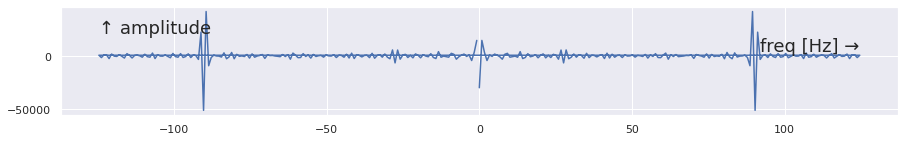

 
TWT  451


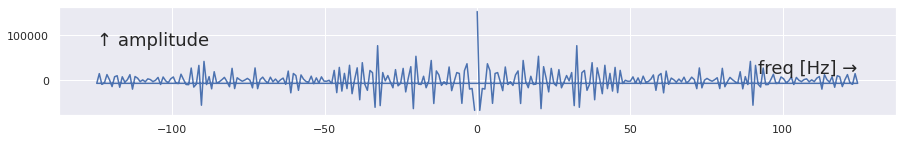

In [51]:
def fourier_visual_freq_domain(twt):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  sample_rate = 250 #Hz
  signal = data[twt,:]
  #Taper the signal by multiplying it by a window function
  signal = signal * np.blackman(signal.size)
  #Frequency domain. It consists of an array of Fourier coefficients:
  S = np.fft.fft(signal)
  freq = np.fft.fftfreq(signal.size, d=1/sample_rate)
  x, y = freq[:S.size], S[:S.size] 
  fig, ax = plt.subplots(figsize=(15, 2))
  ax.plot(np.real(x), np.real(y))
  ax.text(min(np.real(x)), 0.5*max(np.real(y)), "↑ amplitude", fontsize=18)
  ax.text(max(np.real(x)), 0.1*max(np.real(y)), "freq [Hz] →", fontsize=18, ha='right')
  plt.show()

#Check the 1st and Last TWT
for i in range(0, np.size(data,0)):
  if i == 0 or i == np.size(data,0)-1:
    print ('TWT ', i+1)
    fourier_visual_freq_domain(twt=i)
    print(' ')

### **Max Absolute Amplitude of the Noise for Each TWT for Frequency between 80 - 90 Hz**

From below, we found out that for each TWT, the noise is around 50,000

In [52]:
def fourier_max_abs_amp(twt, freq_min, freq_max):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  signal = data[twt,:]
  signal = signal * np.blackman(signal.size)
  S = np.fft.fft(signal)
  freq = np.fft.fftfreq(signal.size, d=1/sample_rate)
  x, y = freq[:S.size], np.abs(S[:S.size])
  noise_index = np.where((x>freq_min)&(x<freq_max)) #find the noise index based on noise amplitude
  #S[noise_index] = 0
  x, y = freq[:S.size], np.abs(S[:S.size])
  return ('TWT', i+1 , max(y[noise_index])) #x[noise_index] is noise frequency

freq_min, freq_max = 80, 90
end_loop = np.size(data,0) #size of rows in data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
noise_freq = []
for i in range(0, end_loop):
  # Note that each trace has different configuration of frequency and amplitude noise.
  noise_freq.append(fourier_max_abs_amp(twt=i , freq_min = freq_min, freq_max = freq_max))
noise_freq

[('TWT', 1, 47535.754541987524),
 ('TWT', 2, 47535.754541987524),
 ('TWT', 3, 47535.754541987524),
 ('TWT', 4, 47535.754541987524),
 ('TWT', 5, 47535.754541987524),
 ('TWT', 6, 47535.754541987524),
 ('TWT', 7, 47535.754541987524),
 ('TWT', 8, 47535.754541987524),
 ('TWT', 9, 47535.754541987524),
 ('TWT', 10, 47535.754541987524),
 ('TWT', 11, 47535.754541987524),
 ('TWT', 12, 47535.754541987524),
 ('TWT', 13, 47535.754541987524),
 ('TWT', 14, 47535.754541987524),
 ('TWT', 15, 48618.552202000305),
 ('TWT', 16, 52927.29872224659),
 ('TWT', 17, 53133.30458522572),
 ('TWT', 18, 51269.38495907148),
 ('TWT', 19, 53171.16669918761),
 ('TWT', 20, 51740.66718865916),
 ('TWT', 21, 51947.21650780828),
 ('TWT', 22, 53034.70576788412),
 ('TWT', 23, 50912.12059077281),
 ('TWT', 24, 50365.037678998066),
 ('TWT', 25, 49380.215764676104),
 ('TWT', 26, 50582.05611408319),
 ('TWT', 27, 51017.325383189396),
 ('TWT', 28, 48658.97951687874),
 ('TWT', 29, 54326.53458313594),
 ('TWT', 30, 54596.49096042257),
 

### **Single TWT (or Layer)**
**Time Domain -> Freq domain using Fourier Transform (find noise between 80-90 Hz) -> Clean Freq Domain -> Inverse Fourier**

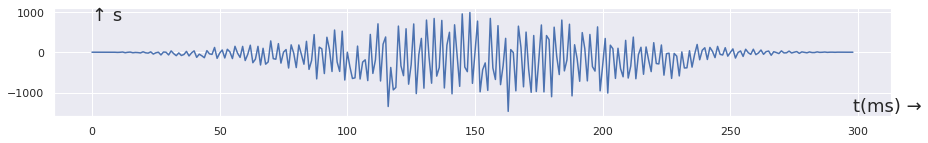

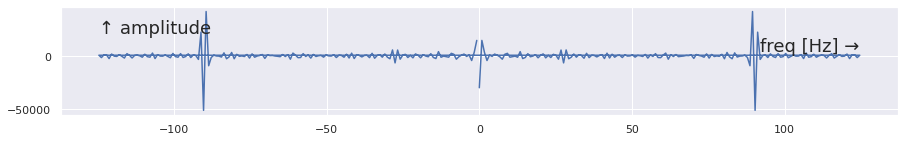

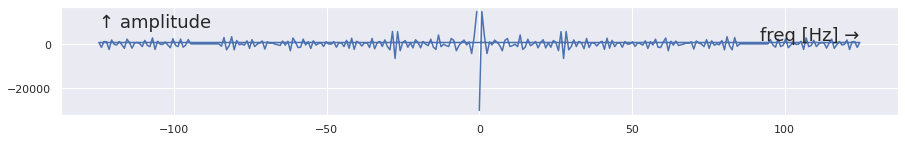

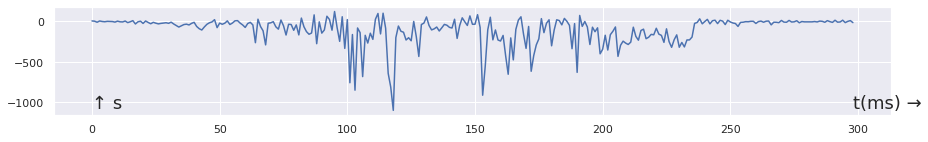

In [53]:
def visual_time_domain(twt):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  signal = data[twt,:]
  signal = signal * np.blackman(signal.size)
  samples = np.array(np.arange (0, signal.size, 1))
  fig, ax = plt.subplots(figsize=(15, 2))
  ax.text(0, 0.8*max(signal), "↑ s", fontsize=18)
  ax.text(max(samples), min(signal), "t(ms) →", fontsize=18)
  ax.plot(samples, signal)
  plt.show()
  print(' ')

def fourier_visual_freq_domain(twt):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  sample_rate = 250 #Hz
  signal = data[twt,:]
  #Taper the signal by multiplying it by a window function
  signal = signal * np.blackman(signal.size)
  #Frequency domain. It consists of an array of Fourier coefficients:
  S = np.fft.fft(signal)
  freq = np.fft.fftfreq(signal.size, d=1/sample_rate)
  x, y = freq[:S.size], S[:S.size] 
  fig, ax = plt.subplots(figsize=(15, 2))
  ax.plot(np.real(x), np.real(y))
  ax.text(min(np.real(x)), 0.5*max(np.real(y)), "↑ amplitude", fontsize=18)
  ax.text(max(np.real(x)), 0.1*max(np.real(y)), "freq [Hz] →", fontsize=18, ha='right')
  plt.show()
  print(' ')

def fourier_cleansing(twt, freq_min, freq_max):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  sample_rate = 250 #Hz
  signal = data[twt,:]
  signal = signal * np.blackman(signal.size)
  S = np.fft.fft(signal)
  freq = np.fft.fftfreq(signal.size, d=1/sample_rate)
  x, y = freq[:S.size], S[:S.size]
  #Find the index where the frequency is between freq_min and freq_max
  noise_index = np.where((x>freq_min)&(x<freq_max))
  S[noise_index] = 0
  #since it has negative frequency, find the index where the frequency is between -freq_max and -freq_min
  noise_index = np.where((x>-freq_max)&(x<-freq_min))
  S[noise_index] = 0
  x, y = freq[:S.size], S[:S.size]
  return (list(x),list(y)) #x,y is clean data

def inverse_fourier(twt):
  s = np.fft.ifft(clean_amp[twt,:])
  return (s) 

#_______________________________________________________________________________
twt_select = 1 #The first layer in data set is index 0
#1. Create time domain
visual_time_domain(twt=twt_select-1)

#2. Create frequency domain
fourier_visual_freq_domain (twt=twt_select-1)

#3. Remove amplitude where the noise freq_max and noise freq_min exist by calling fourier_cleansing(twt, freq_min, freq_max)
freq_min = 85
freq_max = 95
clean_freq = []
clean_amp = []
result = fourier_cleansing(twt=twt_select-1, freq_min = freq_min, freq_max = freq_max)
clean_freq.append(list(result[0]))
clean_amp.append(list(result[1]))
clean_freq, clean_amp = np.transpose(clean_freq),np.transpose(clean_amp)
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(np.real(clean_freq), np.real(clean_amp))
ax.text(min(np.real(clean_freq)), 0.5*max(np.real(clean_amp)), "↑ amplitude", fontsize=18)
ax.text(max(np.real(clean_freq)), 0.1*max(np.real(clean_amp)), "freq [Hz] →", fontsize=18, ha='right')
plt.show()

#4. Inverse the clean_amp by calling inverse_fourier(twt = twt_select-1)
clean_freq, clean_amp = np.transpose(clean_freq),np.transpose(clean_amp)
clean_s = []
clean_s.append(inverse_fourier(twt = twt_select-1))
import pandas as pd
clean_s = pd.DataFrame(clean_s)
clean_s_real = np.array(clean_s[0:]).real
clean_s_real = np.transpose(clean_s_real)
signal = data[twt_select-1,:]
samples = np.array(np.arange (0,signal.size , 1))
fig, ax = plt.subplots(figsize=(15, 2))
ax.plot(samples, clean_s_real)
ax.text(0, 0.5*min(signal), "↑ s", fontsize=18)
ax.text(max(samples), 0.5* min(signal), "t(ms) →", fontsize=18)
plt.show()


### **Clean Image using Method 1:** signal = data[twt,:], it is defined that **signal is per layer (TWT)**

451 299 451 299
299 451


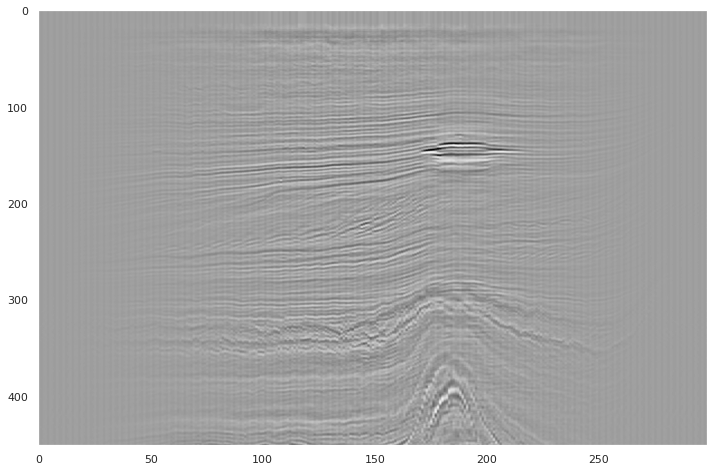

In [54]:
#1. Noise Amplitude and Frequencies cleaning for each TWT (or horizontal layer)
data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
sample_rate=250
#Frequency to be deleted
freq_min = 80 #Hz
freq_max =  90 #Hz

def fourier_cleansing(twt, freq_min, freq_max):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  sample_rate = 250 #Hz
  signal = data[twt,:]
  signal = signal * np.blackman(signal.size)
  S = np.fft.fft(signal)
  freq = np.fft.fftfreq(signal.size, d=1/sample_rate)
  x, y = freq[:S.size], S[:S.size]
  noise_index = np.where((x>freq_min)&(x<freq_max))
  S[noise_index] = 0
  noise_index = np.where((x>-freq_max)&(x<-freq_min))
  S[noise_index] = 0 
  x, y = freq[:S.size], S[:S.size]
  return (list(x),list(y)) #x,y is clean data

end_loop = np.size(data,0) #size of rows in data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
clean_freq = []
clean_amp = []
for i in range(0, end_loop ):
    result = fourier_cleansing(twt=i, freq_min = freq_min, freq_max = freq_max)
    clean_freq.append(list(result[0]))
    clean_amp.append(list(result[1]))
print(len(clean_freq),len(clean_freq[0]),len(clean_amp), len(clean_amp[0]))

#2. Reconstruct the wiggle using clean amplitude and clean frequencies
import pandas as pd
clean_amp = pd.DataFrame(clean_amp)
clean_amp = np.array(clean_amp[0:])
clean_freq = pd.DataFrame(clean_freq)
clean_freq = np.array(clean_freq[0:])

def inverse_fourier(twt_i):
  s = np.fft.ifft(clean_amp[twt_i,:])
  return (s) 

end_loop = np.size(data,0) #size of rows in data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
clean_s = []
for i in range(0, end_loop):
  clean_s.append(inverse_fourier(twt_i = i))
print(len(inverse_fourier(0)),len(clean_s))
import pandas as pd
clean_s = pd.DataFrame(clean_s)
clean_s_real = np.array(clean_s[0:]).real
clean_s_imag = np.array(clean_s[0:]).imag

def print_seis(seismic_real):
  plt.figure(figsize=(12, 8))
  plt.imshow(seismic_real, cmap='Greys', aspect='auto')
  plt.grid(False)
  plt.show()
  
print_seis(clean_s_real)

# **Method 2: Clean Image based on wiggle or signal = data[:,trace], it is defined that signal is per trace**

### **Clean Image using Method 2**: signal = data[:,trace], it is defined that **signal is per Trace**

299 451 299 451


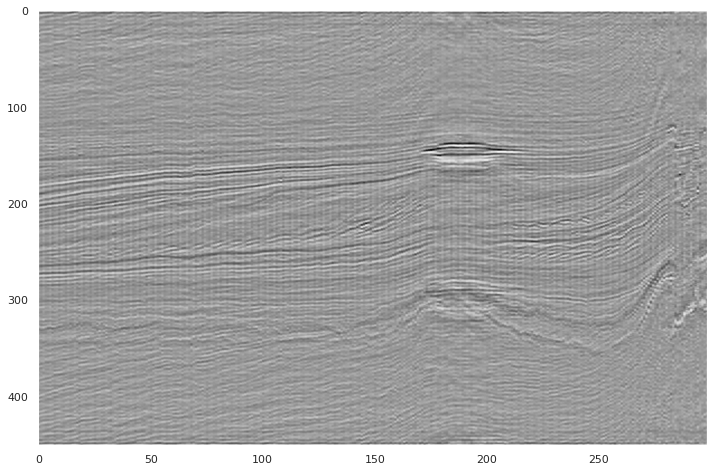

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

 #1. Noise Amplitude and Frequencies cleaning for each traces
data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
TWT_length = np.size(data,0) #ms
#amplituded to be deleted
amp_min = 10000 #Hz
amp_max = 200000 #Hz, put [] and change logic sign (to <) if want to delete freq below than or change logic sign (to >) if want to delete freq greater than
logic = '<'
sample_rate = 250 

def fourier_cleansing(TWT_length, trace, freq_min, freq_max, logic):
  data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
  signal = data[:TWT_length,trace]
  signal = signal * np.blackman(signal.size)
  S = np.fft.fft(signal)
  freq = np.fft.fftfreq(signal.size, d=1/sample_rate)
  x, y = freq[:S.size], S[:S.size]
  if freq_max != []:
    noise_index = np.where((y>amp_min)&(y<amp_max))
    S[noise_index] = 0
  else:
    if logic == '<':
      noise_index = np.where(y<amp_min)
      S[noise_index] = 0
    else:  
      noise_index = np.where(y>amp_min)
      S[noise_index] = 0
  x, y = freq[:S.size], S[:S.size]
  return (list(x),list(y)) #x,y is clean data

end_loop = np.size(data,1) #size of columns in data = np.load('data/FourierTransformSeismic/noisy_seismic.npy')
clean_freq = []
clean_amp = []
for i in range(0, end_loop):
    result = fourier_cleansing(TWT_length = TWT_length, trace=i, freq_min = freq_min, freq_max = freq_max, logic =logic)
    clean_freq.append(list(result[0]))
    clean_amp.append(list(result[1]))
print(len(clean_freq),len(clean_freq[0]),len(clean_amp), len(clean_amp[0]))
clean_amp = pd.DataFrame(clean_amp)
clean_amp = np.array(clean_amp[0:])
clean_freq = pd.DataFrame(clean_freq)
clean_freq = np.array(clean_freq[0:])

#2. Reconstruct the wiggle using clean amplitude and clean frequencies
def inverse_fourier(twt):
  s = np.fft.ifft(clean_amp[twt,:])
  return (s) 

from contextlib import suppress
with suppress(Exception):
  end_loop = np.size(data,0) #size of columns in data = np.load('data/FourierTransformSeismic/noisy_seismic.npy'). Columns represent number of traces
  clean_s = []
  for i in range(0, end_loop):
    clean_s.append(inverse_fourier(twt = i))
  print(len(inverse_fourier(0)),len(clean_s))

clean_s = pd.DataFrame(clean_s)
clean_s = np.array(clean_s[0:])
clean_s_real = clean_s.real
clean_s_real = clean_s_real.transpose()

def print_seis(seismic):
  plt.figure(figsize=(12, 8))
  plt.imshow(seismic, cmap='Greys', aspect='auto')
  plt.grid(False)
  plt.show()
print_seis(clean_s_real)